In [4]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine(
   "mssql+pyodbc://@localhost/Northwind?driver=ODBC+Driver+17+for+SQL+Server"
) 

query = """ SELECT CustomerID,EmployeeID,MONTH(OrderDate) as OrderMonth, YEAR(OrderDate) as OrderYear,
COUNT(case when ShippedDate is not null then OrderID end) as Shipped,
COUNT(case when ShippedDate is null then OrderID end) as NotShipped
from Orders
Group by CustomerID, EmployeeID, MONTH(OrderDate), YEAR(OrderDate) """
df = pd.read_sql(query, engine)

print(df)


    CustomerID  EmployeeID  OrderMonth  OrderYear  Shipped  NotShipped
0        ALFKI           1           1       1998        1           0
1        ALFKI           1           3       1998        1           0
2        ALFKI           3           4       1998        1           0
3        ALFKI           4          10       1997        2           0
4        ALFKI           6           8       1997        1           0
..         ...         ...         ...        ...      ...         ...
801      WOLZA           4           2       1998        1           0
802      WOLZA           4           4       1998        1           0
803      WOLZA           5           2       1998        1           0
804      WOLZA           6           7       1997        1           0
805      WOLZA           8           4       1998        1           0

[806 rows x 6 columns]


In [5]:
df.describe()

,EmployeeID,OrderMonth,OrderYear,Shipped,NotShipped
count,806.000000,806.000000,806.000000,806.000000,806.000000
mean,4.411911,6.050868,1997.141439,1.003722,0.026055
std,2.510907,3.647668,0.699490,0.231089,0.167008
min,1.000000,1.000000,1996.000000,0.000000,0.000000
25%,2.000000,3.000000,1997.000000,1.000000,0.000000
50%,4.000000,5.000000,1997.000000,1.000000,0.000000
75%,7.000000,9.000000,1998.000000,1.000000,0.000000
max,9.000000,12.000000,1998.000000,2.000000,2.000000


In [6]:
import pyodbc
import pandas as pd

conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost;"
    "DATABASE=Northwind_DWH;"
    "Trusted_Connection=yes;"
)


In [7]:
dwh = "C:/Users/laoua/Downloads/final_dwh.xlsx"

cursor = conn.cursor()
df_customers = pd.read_excel(dwh, sheet_name="DimCustomer")

for _, row in df_customers.iterrows():
    cursor.execute("""
        INSERT INTO DimCustomer (CustomerID, CompanyName, ContactName, City, Country)
        VALUES (?, ?, ?, ?, ?)
    """,
    row["CustomerID"],
    row["CompanyName"],
    row["ContactName"],
    row["City"],
    row["Country"]
    )

conn.commit()


In [8]:
cursor.execute("SET IDENTITY_INSERT DimEmployee ON")

df_employee = pd.read_excel(dwh, sheet_name="DimEmployee")

for _, row in df_employee.iterrows():
    cursor.execute("""
        INSERT INTO DimEmployee (EmployeeKey, EmployeeID, FirstName, LastName, City, Country)
        VALUES (?, ?, ?, ?, ?, ?)
    """,
    int(row["EmployeeKey"]),
    int(row["EmployeeID"]),
    str(row["FirstName"]),
    str(row["LastName"]),
    str(row["City"]),
    str(row["Country"])
    )

cursor.execute("SET IDENTITY_INSERT DimEmployee OFF")

conn.commit()
print("DimEmployee inserted successfully with explicit EmployeeKey!")

    


In [24]:
cursor.execute("SET IDENTITY_INSERT DimTime ON")

for _, row in df_time.iterrows():
    cursor.execute("""
        INSERT INTO DimTime (TimeKey, OrderMonth, OrderYear)
        VALUES (?, ?, ?)
    """,
    int(row["TimeKey"]),
    int(row["OrderMonth"]),
    int(row["OrderYear"])
    )

cursor.execute("SET IDENTITY_INSERT DimTime OFF")

conn.commit()
print("DimTime data inserted successfully with TimeKey!")



DimTime data inserted successfully with TimeKey!


In [9]:

f_fact = pd.read_excel(dwh, sheet_name="FactOrders")

for _, row in df_fact.iterrows():
    cursor.execute("""
        INSERT INTO FactOrders (TimeKey, CustomerKey, EmployeeKey, ShippedOrders, NotShippedOrders)
        VALUES (?, ?, ?, ?, ?)
    """,
    int(row["DimTime"]),
    int(row["DimCustomers"]),
    int(row["DimEmployees"]),
    int(row["ShippedOrders"]),
    int(row["NotShippedOrders"])
    )

conn.commit()
print("FactOrders inserted successfully!")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
fact = pd.read_excel(dwh, sheet_name="FactOrders")
customers = pd.read_excel(dwh, sheet_name="DimCustomer")
employees = pd.read_excel(dwh, sheet_name="DimEmployee")
time = pd.read_excel(dwh, sheet_name="DimTime")


In [19]:
df = (
    fact
    .merge(customers, left_on="DimCustomers", right_on="CustomerKey", how="left")
    .merge(employees, left_on="DimEmployees", right_on="EmployeeKey", how="left")
    .merge(time, left_on="DimTime", right_on="TimeKey", how="left")
)

df.head()



,DimTime,DimCustomers,DimEmployees,ShippedOrders,NotShippedOrders,CustomerKey,CustomerID,CompanyName,ContactName,City_x,Country_x,EmployeeKey,EmployeeID,LastName,FirstName,City_y,Country_y,TimeKey,OrderMonth,OrderYear
0,15,3,4,1,0,3,ANTON,Antonio Moreno Taquer a,Antonio Moreno,M xico D.F.,Mexico,4,4,Peacock,Margaret,Redmond,USA,15,5,1997
1,12,2,4,1,0,2,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,M xico D.F.,Mexico,4,4,Peacock,Margaret,Redmond,USA,12,3,1998
2,12,4,4,1,0,4,AROUT,Around the Horn,Thomas Hardy,London,UK,4,4,Peacock,Margaret,Redmond,USA,12,3,1998
3,7,4,4,1,0,4,AROUT,Around the Horn,Thomas Hardy,London,UK,4,4,Peacock,Margaret,Redmond,USA,7,10,1997
4,6,4,4,1,0,4,AROUT,Around the Horn,Thomas Hardy,London,UK,4,4,Peacock,Margaret,Redmond,USA,6,2,1998


In [20]:
df.info()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DimTime           854 non-null    int64 
 1   DimCustomers      854 non-null    int64 
 2   DimEmployees      854 non-null    int64 
 3   ShippedOrders     854 non-null    int64 
 4   NotShippedOrders  854 non-null    int64 
 5   CustomerKey       854 non-null    int64 
 6   CustomerID        854 non-null    object
 7   CompanyName       854 non-null    object
 8   ContactName       854 non-null    object
 9   City_x            854 non-null    object
 10  Country_x         854 non-null    object
 11  EmployeeKey       854 non-null    int64 
 12  EmployeeID        854 non-null    int64 
 13  LastName          854 non-null    object
 14  FirstName         854 non-null    object
 15  City_y            854 non-null    object
 16  Country_y         854 non-null    object
 17  TimeKey         

DimTime             0
DimCustomers        0
DimEmployees        0
ShippedOrders       0
NotShippedOrders    0
CustomerKey         0
CustomerID          0
CompanyName         0
ContactName         0
City_x              0
Country_x           0
EmployeeKey         0
EmployeeID          0
LastName            0
FirstName           0
City_y              0
Country_y           0
TimeKey             0
OrderMonth          0
OrderYear           0
dtype: int64

In [21]:
df["TotalOrders"] = df["ShippedOrders"] + df["NotShippedOrders"]
df["ShippingRate"] = df["ShippedOrders"] / df["TotalOrders"]


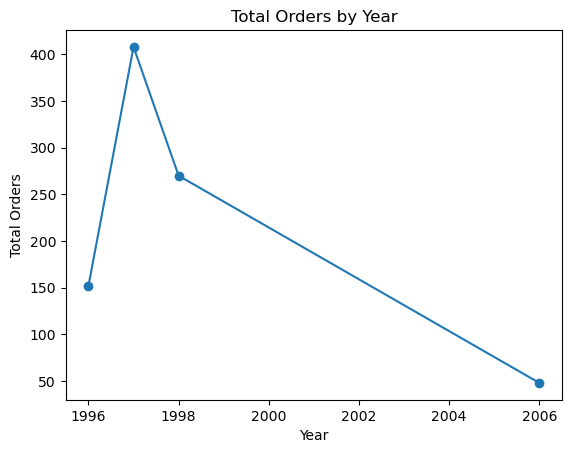

In [22]:
orders_by_year = df.groupby("OrderYear")["TotalOrders"].sum()

orders_by_year.plot(kind="line", marker="o")
plt.title("Total Orders by Year")
plt.xlabel("Year")
plt.ylabel("Total Orders")
plt.show()


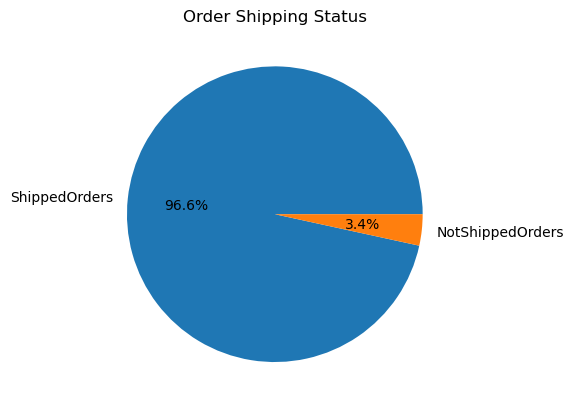

In [23]:
status = df[["ShippedOrders", "NotShippedOrders"]].sum()

status.plot(kind="pie", autopct="%1.1f%%")
plt.title("Order Shipping Status")
plt.ylabel("")
plt.show()


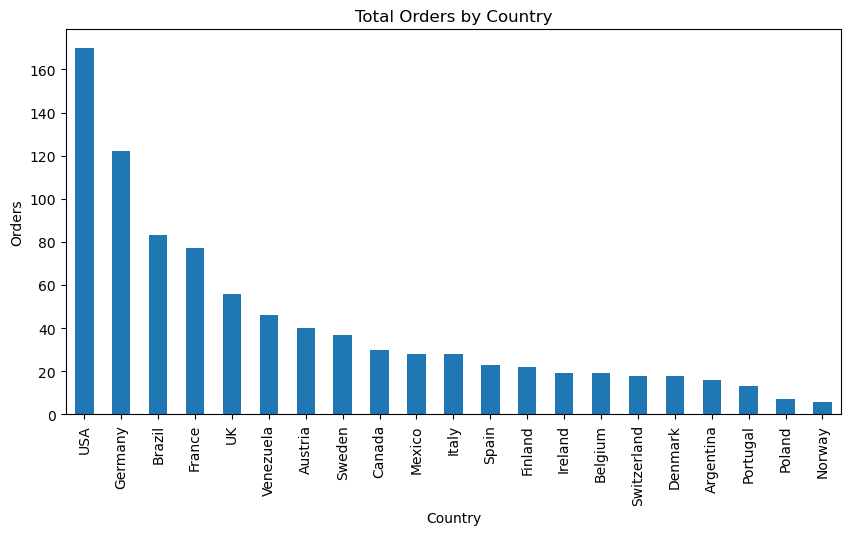

In [25]:
orders_country = df.groupby("Country_x")["TotalOrders"].sum().sort_values(ascending=False)

orders_country.plot(kind="bar", figsize=(10,5))
plt.title("Total Orders by Country")
plt.xlabel("Country")
plt.ylabel("Orders")
plt.show()


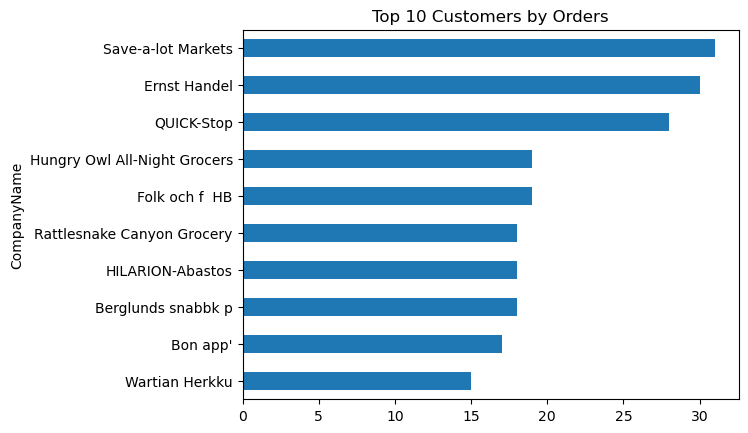

In [26]:
top_customers = df.groupby("CompanyName")["TotalOrders"].sum().sort_values(ascending=False).head(10)

top_customers.plot(kind="barh")
plt.title("Top 10 Customers by Orders")
plt.gca().invert_yaxis()
plt.show()
